In [18]:
from dataset_test import METRLADatasetLoader;

In [19]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset();

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

import random
import gc

In [20]:
import collections

In [21]:
adj_mat = [[0 for i in range(207)] for j in range(207)]
edge_attr = train_dataset[0].edge_attr
src = list(train_dataset[0].edge_index[0])
dest = list(train_dataset[0].edge_index[1])
for i in range(len(src)):
    adj_mat[int(src[i])][int(dest[i])] = float(edge_attr[i])
    if adj_mat[int(dest[i])][int(src[i])] == 0:
        adj_mat[int(dest[i])][int(src[i])] = float(edge_attr[i])

    

In [22]:
import pandas as pd
dataFrame = pd.DataFrame(adj_mat)


In [23]:
dic_speed = collections.defaultdict(list)
dic_density = collections.defaultdict(list)
limit = 12
test_train_dataset = train_dataset[1255 : 1268]
for dataset_snapshot in test_train_dataset:
    if(limit):
        for index, sensor in enumerate(dataset_snapshot.x):
            dic_speed[index].append(float(sensor[0][0]))
            dic_density[index].append(float(sensor[1][0]))
            
        limit -= 1
        
        
    

In [24]:
import numpy as np
import pandas as pd

# Example: Create a DataFrame with density values for each sensor
# Replace this example data with your actual sensor data

df_speed = pd.DataFrame(dic_speed)


# Calculate the correlation matrix
correlation_matrix_speed = df_speed.corr()
spearman_speed = df_speed.corr(method = "spearman")

In [25]:
adj_mat[2]

[0,
 0.7174379229545593,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.5831708908081055,
 0.17432716488838196,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.4410549998283386,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.923679769039154,
 0.8189860582351685,
 0,
 0,
 0,
 0,
 0,
 0.3976668119430542,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.16533388197422028,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.2993141710758209,
 0,
 0,
 0,
 0,
 0,
 0.1639307290315628,
 0,
 0,
 0.2702118456363678,
 0,
 0,
 0.13789546489715576,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.48294660449028015,
 0,
 0,
 0,
 0,
 0,
 0.5701920986175537,
 0,
 0,
 0,
 0,
 0,
 

In [26]:
spearman_speed[0][37]

0.33567714406213733

In [27]:
spearman_speed[0][2]

0.13684294763538826

In [28]:
import numpy as np


# Function to calculate correlation between two nodes using adjacency matrix
def calculate_correlation(node1, node2, correlation):
    return correlation[node1][node2] * ( adj_mat[node1][node2] )

# Function to grow subgraph using BFS
def grow_subgraph(adj_matrix, start_node, threshold, correlation_matrix):
    subgraph = set()
    queue = [start_node]
    while queue:
        current_node = queue.pop(0)
        if current_node not in subgraph:
            subgraph.add(current_node)
            neighbors = [x for x in range(len(adj_mat[0])) if adj_mat[current_node][x] > 0 and x != current_node]
            for neighbor in neighbors:
                if neighbor in unvisited_nodes:
                    correlation = calculate_correlation(current_node, neighbor, correlation_matrix)
                    if np.isnan(correlation):
                        correlation = 0
                    correlation_list.append(correlation)
                    if correlation >= threshold:
                        queue.append(neighbor)
    return subgraph

# Set a correlation threshold for subgraph growth
correlation_threshold = 0.2  # Adjust as needed
correlation_list = []
# Create a list to keep track of nodes that are already part of a subgraph
unvisited_nodes = set(range(len(adj_mat[0])))

# Initialize an empty list to store the subgraphs
subgraphs = []

# Iterate through unvisited nodes to grow subgraphs
while unvisited_nodes:
    node = unvisited_nodes.pop()
    subgraph = grow_subgraph(adj_mat, node, correlation_threshold, spearman_speed)
    subgraphs.append(subgraph)
    unvisited_nodes = unvisited_nodes.difference(subgraph)

# Print the resulting subgraphs
for i, subgraph in enumerate(subgraphs):
    print(f"Subgraph {i + 1}: {subgraph}")

Subgraph 1: {0, 67, 36, 37, 199, 140, 13, 142, 111, 143, 145, 114, 115, 116, 109, 54, 51, 58}
Subgraph 2: {1, 135, 177, 184, 123}
Subgraph 3: {2, 132, 7, 11, 152, 28, 167, 178, 53, 55, 183, 201, 78, 79, 85, 105, 106, 107, 110}
Subgraph 4: {192, 3, 5}
Subgraph 5: {33, 4, 6, 15}
Subgraph 6: {8, 185}
Subgraph 7: {9}
Subgraph 8: {10, 156}
Subgraph 9: {128, 12, 17, 20, 22, 154, 155, 157, 159, 160, 161, 162, 163, 32, 40, 176, 187, 188, 191, 193, 195, 68, 198, 70, 206, 80, 83, 90, 96, 97, 98, 102, 103, 122, 127}
Subgraph 10: {130, 131, 137, 141, 14, 146, 150, 151, 158, 164, 41, 43, 47, 52, 60, 190, 63, 69, 71, 72, 73, 75, 204, 77, 76, 81, 82, 84, 87, 88, 113}
Subgraph 11: {101, 166, 133, 134, 138, 16, 29}
Subgraph 12: {18, 35}
Subgraph 13: {39, 74, 175, 19, 119, 57, 94}
Subgraph 14: {200, 121, 50, 21}
Subgraph 15: {165, 174, 23}
Subgraph 16: {168, 169, 42, 171, 173, 24, 62}
Subgraph 17: {129, 49}
Subgraph 18: {136}
Subgraph 19: {139}
Subgraph 20: {144, 91, 93}
Subgraph 21: {147}
Subgraph 22: 

In [29]:
train_dataset[1255].x[8][0] = torch.tensor([-0.35, -0.67, -0.98, -1.05, -1.32, -1.72, -1.98, -2.05, -1.97, -2.22, -2.23, -2.32])
print(train_dataset[1255].x[8][0])

tensor([-0.3500, -0.6700, -0.9800, -1.0500, -1.3200, -1.7200, -1.9800, -2.0500,
        -1.9700, -2.2200, -2.2300, -2.3200])


In [30]:
train_dataset[1255].x[185][0] = torch.tensor([-0.35, -0.67, -0.98, -1.05, -1.32, -1.72, -1.98, -2.05, -1.97, -2.22, -2.23, -2.32])
print(train_dataset[1255].x[185][0])

tensor([-0.3500, -0.6700, -0.9800, -1.0500, -1.3200, -1.7200, -1.9800, -2.0500,
        -1.9700, -2.2200, -2.2300, -2.3200])


In [31]:
macro = collections.defaultdict(list)
for index,subgraph in enumerate(subgraphs):
    for i in range(len(dic_speed[0])):
        temp = []
        for sensor in subgraph:
            temp.append(dic_speed[sensor][i])
        macro[index].append(np.mean(temp))
            


In [32]:
macro_df = pd.DataFrame(macro)


# Calculate the correlation matrix
correlation_matrix_macros = macro_df.corr()

In [33]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h;

# GPU support
device = torch.device('cpu') # cuda
subset = 2000
# gc.collect() # garbage collector
# torch.cuda.empty_cache() # cuda

In [ ]:
model_speed = TemporalGNN(node_features=2, periods=12).to(device)
model_density = TemporalGNN(node_features=2, periods=12).to(device)
optimizer_speed = torch.optim.Adam(model_speed.parameters(), lr=0.01)
optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.01)
model_speed.train()
model_density.train()

print("Running training...")
for epoch in range(20):
    loss_speed = 0
    loss_density = 0
    for step in range(subset):
        snapshot = train_dataset[step].to(device) # shift snapshot subset every epoch
#         snapshot = train_dataset[(epoch * subset) + step].to(device) # shift snapshot subset every epoch, do this later cause better training
        # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
        # Get model predictions
        y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
        y_hat_density = model_density(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
        loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)

    loss_speed = loss_speed / (step + 1)
    loss_density = loss_density / (step + 1)
    loss_speed.backward()
    loss_density.backward()
    optimizer_speed.step()
    optimizer_speed.zero_grad()
    optimizer_density.step()
    optimizer_density.zero_grad()
    print("Epoch speed {} train MSE: {:.4f}".format(epoch, loss_speed.item()))
    print("Epoch density {} train MSE: {:.4f}".format(epoch, loss_density.item()))

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./traffic_prediction_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_speed, file)

In [34]:
import pickle

model_pkl_file = "./traffic_prediction_model.pkl"

model_speed = pickle.load(open(model_pkl_file, 'rb'))

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "./traffic_prediction_density_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(model_density, file)

In [35]:
import pickle

model_pkl_file = "./traffic_prediction_density_model.pkl"

model_density = pickle.load(open(model_pkl_file, 'rb'))

In [36]:
model_speed.eval()
model_density.eval()
loss_speed = 0
loss_density = 0
horizon = 12

# Store for analysis
predictions_speed = []
labels_speed = []
predictions_density = []
labels_density = []
anomalies_speed = [test_dataset[i].y.permute(1, 0, 2)[0] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph
anomalies_density = [test_dataset[i].y.permute(1, 0, 2)[1] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

for step in range(horizon):
    snapshot = train_dataset[step + 1255].to(device)
    # Get predictions
    y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
    y_hat_density = model_density(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
    loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)
    if step > 1:
        # acceleration or deviation
        acc_speed = torch.mean(abs((y_hat_speed - predictions_speed[-1]) / predictions_speed[-1]))
        if acc_speed > 1: # random value for now
            anomalies_speed[step] = y_hat_speed # mark point on predicted graph if it exceeds some threshold of acceleration
        acc_density = torch.mean(abs((y_hat_density - predictions_density[-1]) / predictions_density[-1]))
        if acc_density > 1: # random value for now
            anomalies_density[step] = y_hat_density # mark point on predicted graph if it exceeds some threshold of acceleration
    labels_speed.append(snapshot.y.permute(1, 0, 2)[0])
    labels_density.append(snapshot.y.permute(1, 0, 2)[1])
    predictions_speed.append(y_hat_speed)
    predictions_density.append(y_hat_density)

loss_speed = loss_speed / (step+1)
loss_speed = loss_speed.item()
loss_density = loss_density / (step+1)
loss_density = loss_density.item()

print("Test speed MSE: {:.4f}".format(loss_speed))
print("Test density MSE: {:.4f}".format(loss_density))

# gc.collect()
# torch.cuda.empty_cache()

Test speed MSE: 0.4897
Test density MSE: 0.0228


In [37]:
y_hat_speed.shape

torch.Size([207, 12])

In [38]:
import numpy as np

sensor = 185
timestep = 0
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_speed])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_speed])
anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_speed])
preds1 = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_density])
labs1  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_density])
anoms1 = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_density])

<Axes: >

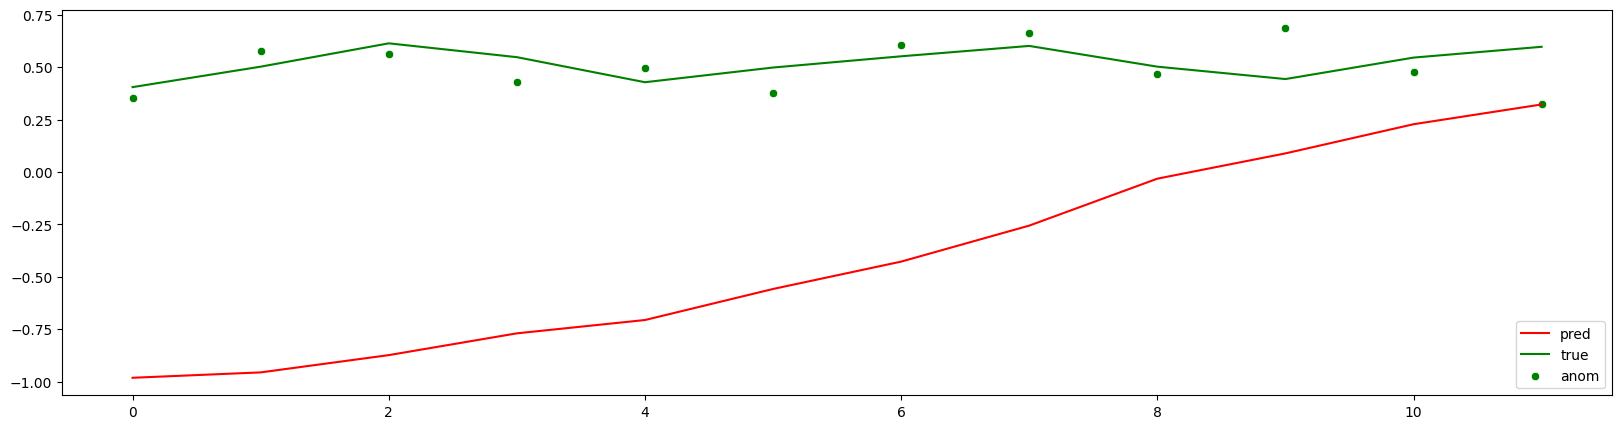

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true", color='green')
sns.scatterplot(data=anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

In [21]:
train_dataset[1255].y[185][0]

tensor([0.4047, 0.5022, 0.6136, 0.5476, 0.4280, 0.4981, 0.5517, 0.6012, 0.5022,
        0.4431, 0.5455, 0.5971])

<Axes: >

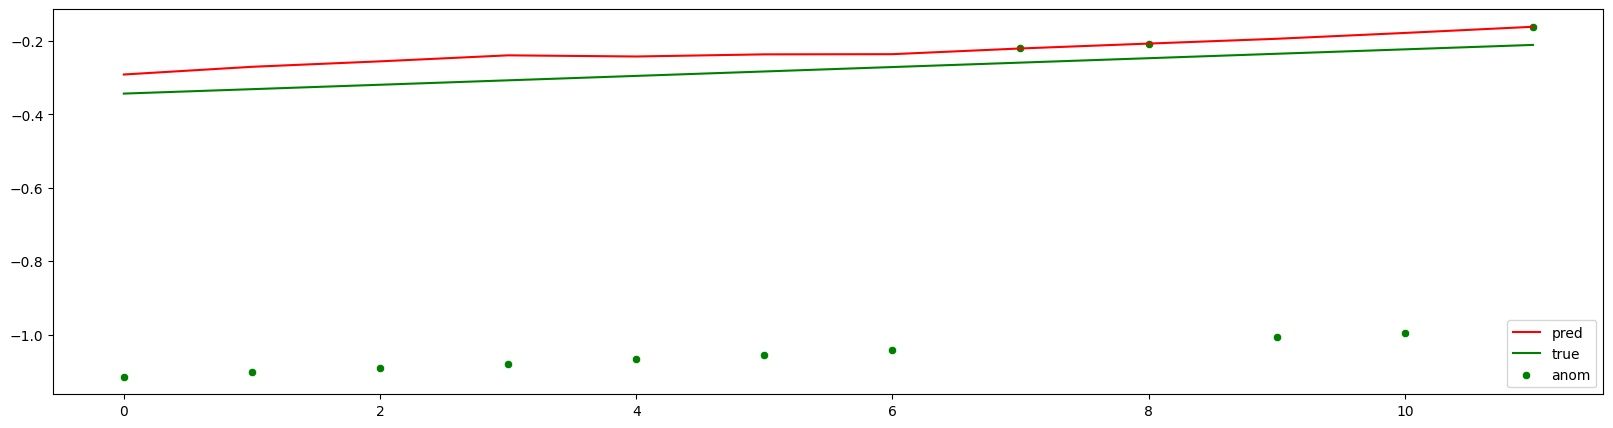

In [40]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds1, label="pred", color='red')
sns.lineplot(data=labs1, label="true", color='green')

sns.scatterplot(data=anoms1, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

In [41]:
def subgraph_anomaly_detection(subgraph, prev_hour, curr_hour):
    #cur_hour -> prev_hour, pred_hour -> curr_hour
    #dimensions: subgraph-set, curr_hour-snapshot of graph during current hour (207x2x12), pred_hour-model predicted snapshot of graph for the next hour (207x12)
    prev_pred_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(prev_hour[sensor][timestep])
        prev_pred_means.append(np.mean(temp))
    #print("prev_means = ", prev_pred_means)
    base = np.mean(prev_pred_means)
    #print("base = ", base)
    dev = np.std(prev_pred_means)
    #print("dev = ", dev)
    cur_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(curr_hour[sensor][0][timestep])
        cur_means.append(np.mean(temp))
    #print("cur_means = ", cur_means)
    anoms = []
    for i in cur_means:
        anoms.append(max(0.0, abs(i - base) - dev))
    #print("anoms = ", anoms)
    #print("norm = ", np.linalg.norm(anoms))
    return anoms
#     norm_anoms = []
#     if np.linalg.norm(anoms) == 0:
#         return anoms
#     else:
#         print("normalized anoms = ", norm_anoms)
#         for i in anoms:
#             norm_anoms.append(abs(i) / np.linalg.norm(anoms))
#         return norm_anoms

In [42]:
test_snapshot = train_dataset[1255]
predicted = model_speed(test_snapshot.x, test_snapshot.edge_index).detach().cpu().numpy()
predicted_prev = model_speed(train_dataset[1255 - 12].x, train_dataset[1255 - 12].edge_index).detach().cpu().numpy()
print("Actual prev values = ", train_dataset[1255 - 12].x[185][0])
print(subgraph_anomaly_detection(subgraphs[5], predicted, test_snapshot.x))

Actual prev values =  tensor([ 0.7290, -2.6522, -2.6522, -1.2997, -0.3575,  0.3332,  0.2920,  0.7620,
        -2.6522, -2.6522, -2.6522, -2.6522])
[0.3955218, 0.075521775, 0.032167204, 0.10216714, 0.37216723, 0.7721672, 1.0321672, 1.1021671, 1.0221672, 1.2721672, 1.2821672, 1.3721671]


In [43]:
def find_all_subgraph_anomalies(subgraphs, curr_hour, pred_hour):
    anomaly_list = []
    norm_anomaly_list = []
    mean_anomaly_list = {}
    max_val = 0.0
    for index, subgraph in enumerate(subgraphs):
        # ans = subgraph_anomaly_detection(i, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])
        ans = subgraph_anomaly_detection(subgraph, curr_hour, pred_hour)
        anomaly_list.append(ans)
        max_val = max(max_val,max(ans))
    #print("Max : ",max_val)
    for index, anom in enumerate(anomaly_list):
        temp = 0.0
        count = 0
        #print("INDEX ",index)
        #print("Prev : ",anom)
        if(max_val==0):
            norm_anoms = anom
        else:
            norm_anoms = [x/max_val for x in anom]
        #print("Normalized :",norm_anoms)
        norm_anomaly_list.append(norm_anoms)
        for i in norm_anoms:
            if i > 0:
                temp += i
                count += 1
        if(count == 0):
            mean_anomaly_list[index] = temp
        else:
            mean_anomaly_list[index] = temp / count
    return (norm_anomaly_list, mean_anomaly_list)

In [44]:
anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, train_dataset[1255].x)

In [ ]:
anomaly_list

In [ ]:
anomaly_list[16]

In [ ]:
predicted[8]

In [ ]:
train_dataset[1255].x[8][0]

In [ ]:
mean_anomaly_dict

In [45]:
def top_k_anomalous_subgraphs(k, mean_anomaly_dict):
    sorted_mean_anomaly_dict = sorted(mean_anomaly_dict.items(), key = lambda x : x[1], reverse = True)
    top_k_anomaly = [x for x, y in sorted_mean_anomaly_dict]
    return top_k_anomaly[0 : k]
    

In [ ]:
anomalous_subgraphs = top_k_anomalous_subgraphs(15, mean_anomaly_dict)

In [ ]:
anomalous_subgraphs

In [ ]:
subgraphs[52]

In [ ]:
train_dataset[1255].y[95][0]

In [ ]:
train_dataset[1243].y[95][0]

In [ ]:
print(subgraph_anomaly_detection(subgraphs[52], test_snapshot.x, predicted))

In [76]:
def micro_feature_analysis(anomalous_subgraphs, curr_hour, pred_hour):
    anomalous_analysis = {}
    for anomalous_subgraph in anomalous_subgraphs:
        anomalous_analysis[anomalous_subgraph] = {}
        for node in subgraphs[anomalous_subgraph]:
            anomalous_analysis[anomalous_subgraph][node] = []
            
            curr_hour_node_values = [float(x) for x in curr_hour[node][0]]
            curr_hour_node_mean = np.mean(curr_hour_node_values)
            curr_hour_node_dev = np.std(curr_hour_node_values)
#             print("curr node is", node)
#             print("curr node values" , curr_hour_node_values)
#             print("Curr node mean ", curr_hour_node_mean)
#             print("Curr node dev", curr_hour_node_dev)
            
            pred_hour_node_values = [float(x) for x in pred_hour[node]]
            for step in range(len(pred_hour[0])): #the range is basically how many timesteps, which is 12 here
                #anom = max(0.0, abs((pred_hour[node][step] - curr_hour_node_mean) - 2 * curr_hour_node_dev))
                anom = max(0.0, abs(pred_hour[node][step] - curr_hour_node_mean) - 2 * curr_hour_node_dev)
#                 print("predicted at time step", step, " is ", float(pred_hour[node][step]))
                if(anom):
                    anomalous_analysis[anomalous_subgraph][node].append(step)
                    
    return anomalous_analysis
                    
        

In [ ]:
subgraphs[17]

In [50]:
micro_feature_analysis(anomalous_subgraphs, train_dataset[1784].x, predicted)

curr node is 194
curr node values [-2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143, -2.6521542072296143]
Curr node mean  -2.6521542072296143
Curr node dev 0.0
predicted at time step 0  is  0.1507699191570282
predicted at time step 1  is  0.20427030324935913
predicted at time step 2  is  0.15451104938983917
predicted at time step 3  is  0.19640260934829712
predicted at time step 4  is  0.25129392743110657
predicted at time step 5  is  0.1814495325088501
predicted at time step 6  is  0.18021950125694275
predicted at time step 7  is  0.19443829357624054
predicted at time step 8  is  0.22729243338108063
predicted at time step 9  is  0.22252757847309113
predicted at time step 10  is  0.22412699460983276
predicted at time step 11  is  0.16423584520816803
curr node is 42
curr node values [0.33318692445755005, 0.40

{36: {194: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 31: {42: []},
 44: {56: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 6: {16: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  196: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  166: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 29: {38: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 34: {65: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 33: {64: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 24: {26: []},
 48: {101: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 7: {18: [], 35: []},
 14: {133: []},
 46: {95: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 12: {25: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 38: {203: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 15: {134: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}

In [47]:
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [48]:
def prediction_based_anomaly(next_real_values, next_predictions, previous_real_values, previous_predictions, node):
    
#     print(next_real_values)
    # Calculate the residuals for the previous and next 12 timesteps
    previous_residuals = np.array(previous_predictions[node]) - np.array(previous_real_values[node])
    next_residuals = np.array(next_predictions[node]) - np.array(next_real_values[node])

    # Calculate z-scores for the residuals of the previous 12 timesteps
    z_scores_previous = zscore(previous_residuals)
#     print(z_scores_previous,previous_residuals,next_residuals)
    # Define a threshold for anomaly detection based on the z-scores of the previous residuals
    anomaly_threshold = np.mean(np.abs(z_scores_previous))
    
#     print("z scores previous is ", z_scores_previous)
    
#     print("Threshold is ", anomaly_threshold)

    # Calculate z-scores for the residuals of the next 12 timesteps
    z_scores_next = zscore(next_residuals)
#     print("ZSCORES NEXT",z_scores_next)

    # Identify anomalies in the residuals of the next 12 timesteps
    anomalies = np.where(np.abs(z_scores_next) > anomaly_threshold)[0]

#     print("Previous Residuals:", previous_residuals)
#     print("Next Residuals:", next_residuals)
#     print("Anomalies (indices):", anomalies)
    return anomalies
    

In [ ]:
#anomalous_subgraphs, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0]
#anomalous_subgraphs, curr_hour, pred_hour
#next_real_values, next_predictions, previous_real_values, previous_predictions

In [ ]:
next_test_snapshot = train_dataset[1784]
cur_test_snapshot = train_dataset[1784 - 12]
prev_test_snapshot = train_dataset[1784 - 12 - 12]
cur_prediction = model_speed(prev_test_snapshot.x, prev_test_snapshot.edge_index).detach().cpu().numpy()
next_prediction = model_speed(cur_test_snapshot.x, cur_test_snapshot.edge_index).detach().cpu().numpy()
prediction_based_anomaly(next_test_snapshot.x.permute(1, 0, 2)[0], next_prediction ,cur_test_snapshot.x.permute(1, 0, 2)[0], cur_prediction, 48)

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

subgraph_means = {}

for index, subgraph in enumerate(subgraphs):
    node_speeds = []
    for node in subgraph:
        node_speeds.append(torch.mean(train_dataset[9231].x[node][0]))
        
    subgraph_means[index] = np.mean(node_speeds)


# subgraph_means_pd = pd.DataFrame(subgraph_means)    
k_values = range(1, 30)
# k = 2
inertias = []
feature_list = list(subgraph_means.values())

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    #feature_list = list(subgraph_means.values())
    kmeans.fit(np.array(feature_list).reshape(-1, 1))  # X is your data
    inertias.append(kmeans.inertia_)
    
diff1 = np.diff(inertias)
diff2 = np.diff(diff1)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

elbow_point = np.where(diff2 == max(diff2))[0][0] + 2

print("Elbow point is ", elbow_point)
kmeans = KMeans(n_clusters=elbow_point, random_state=0)
kmeans.fit(np.array(feature_list).reshape(-1, 1))
cluster_labels = kmeans.labels_
print("cluster assignments are ,",  cluster_labels)

import matplotlib.pyplot as plt
#Initialize lists to store data points for each cluster
cluster_data = [[] for _ in range(elbow_point)]

# Organize data points by cluster
for i, label in enumerate(cluster_labels):
    if label == cluster:
        cluster_data[label].append(feature_values[i])
# Plot the data points colored by their cluster assignment
for cluster in range(elbow_point):
    plt.scatter(cluster_data[cluster], [cluster] * np.sum(cluster_labels == cluster), label=f'Cluster {cluster}')

plt.xlabel('Feature Value')
plt.ylabel('Cluster')
plt.legend()
plt.title('K-means Clustering with a Single Feature')
plt.show()


In [ ]:
cluster_labels

In [ ]:
feature_list

In [ ]:
print(value_diff)

In [26]:
import random
import copy
injected_dataset = copy.deepcopy(train_dataset)
injected_dict = {}


injected_hours = random.sample(range(0, 2000), 200)
for i in range(200):
    injected_node = random.randrange(0, 207)
    injected_dict[injected_hours[i]] = injected_node
    anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)]
    injected_dataset[injected_hours[i]].x[injected_node][0] = torch.tensor(anomaly_vals)

print(train_dataset[injected_hours[7]].x[injected_dict[injected_hours[7]]][0])
    


tensor([0.3909, 0.2920, 0.3291, 0.4528, 0.3662, 0.5311, 0.3352, 0.4218, 0.5311,
        0.4095, 0.4713, 0.4775])


In [35]:
prob = 0
for timestep in range(12, 2000):
    dic_speed = collections.defaultdict(list)
    limit = 12
    test_train_dataset = train_dataset[i : i + 12]
    for dataset_snapshot in test_train_dataset:
        if(limit):
            for index, sensor in enumerate(dataset_snapshot.x):
                dic_speed[index].append(float(sensor[0][0]))

            limit -= 1
            
    df_speed = pd.DataFrame(dic_speed)
    spearman_speed = df_speed.corr(method = "spearman")
    
    correlation_threshold = 0.2  # Adjust as needed
    # Create a list to keep track of nodes that are already part of a subgraph
    unvisited_nodes = set(range(len(adj_mat[0])))

    # Initialize an empty list to store the subgraphs
    subgraphs = []

    # Iterate through unvisited nodes to grow subgraphs
    while unvisited_nodes:
        node = unvisited_nodes.pop()
        subgraph = grow_subgraph(adj_mat, node, correlation_threshold, spearman_speed)
        subgraphs.append(subgraph)
        unvisited_nodes = unvisited_nodes.difference(subgraph)
        
    injected_test_snapshot = injected_dataset[timestep]
    prev_injected_test_snapshot = injected_dataset[timestep - 12]
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).detach().cpu().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).detach().cpu().numpy()
    
    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x)
    anomalous_subgraphs = top_k_anomalous_subgraphs(15, mean_anomaly_dict)
    
    anom_node_list = []
    if timestep in injected_dict:

        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list.append(node)
                
        if(injected_dict[timestep] in anom_node_list):
            prob += 1
            
print(prob)
            
    
    

104


In [56]:
import random
import copy
injected_dataset = copy.deepcopy(train_dataset)
injected_dict = {}

injected_timesteps = random.sample(range(0, 2000), 200)
prob = 0
count = 0
predicted = []
predicted_prev = []
injected_test_snapshot = []
prev_injected_test_snapshot = []
# prediction_based_flag = 12
for timestep in range(12, 2000):
#     if(not prediction_based_flag):
#         if(timestep in injected_timesteps):
#             micro_prev_predicted = predicted_prev
#             micro_predicted = predicted
#             for subgraph in micro_res:
#                 for node in micro_res[subgraph]:
#     #                 print(micro_prev_predicted)
#                     anomalies = prediction_based_anomaly(injected_test_snapshot.x.permute(1, 0, 2)[0], micro_predicted ,prev_injected_test_snapshot.x.permute(1, 0, 2)[0], micro_prev_predicted, node)
#                     if(len(anomalies) and node in anom_node_list):
#                         prob2 += 1
#     else:
#         prediction_based_flag -= 1
        
    dic_speed = collections.defaultdict(list)
    limit = 12
    test_train_dataset = train_dataset[timestep : timestep + 12]
    for dataset_snapshot in test_train_dataset:
        if(limit):
            for index, sensor in enumerate(dataset_snapshot.x):
                dic_speed[index].append(float(sensor[0][0]))

            limit -= 1
            
    df_speed = pd.DataFrame(dic_speed)
    spearman_speed = df_speed.corr(method = "spearman")
    
    correlation_threshold = 0.2  # Adjust as needed
    # Create a list to keep track of nodes that are already part of a subgraph
    unvisited_nodes = set(range(len(adj_mat[0])))

    # Initialize an empty list to store the subgraphs
    subgraphs = []

    # Iterate through unvisited nodes to grow subgraphs
    while unvisited_nodes:
        node = unvisited_nodes.pop()
        subgraph = grow_subgraph(adj_mat, node, correlation_threshold, spearman_speed)
        subgraphs.append(subgraph)
        unvisited_nodes = unvisited_nodes.difference(subgraph)
        
    if timestep in injected_timesteps:
        injected_subgraph = random.randrange(0, len(subgraphs))
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[timestep] = injected_nodes
        count += len(injected_nodes)
        for node in injected_nodes:
            anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)]
            injected_dataset[timestep].x[node][0] = torch.tensor(anomaly_vals)
            
            
    injected_test_snapshot = injected_dataset[timestep]
    prev_injected_test_snapshot = injected_dataset[timestep - 12]
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).detach().cpu().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).detach().cpu().numpy()
    
    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x)
    anomalous_subgraphs = top_k_anomalous_subgraphs(5, mean_anomaly_dict)
    
    anom_node_list = []
#     Bro, this is for macro feature anomaly detection accuracy? Sure, lets go with that
    if timestep in injected_dict:

        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list.append(node)
                
        for anom_node in injected_dict[timestep]:
            if anom_node in anom_node_list:
                prob += 1
                
#     micro_res = {}    
#     micro_res = micro_feature_analysis(anomalous_subgraphs, injected_test_snapshot.x, predicted)

#     if timestep in injected_dict:
#         for subgraph in micro_res:
#             for node in micro_res[subgraph]:
#                 if(len(micro_res[subgraph][node])):
#                     anom_node_list.append(node)
                
#         for anom_node in injected_dict[timestep]:
#             if anom_node in anom_node_list:
#                 prob += 1
                
print(prob / count)
#print(prob2 / count)
    

0.9981981981981982


In [81]:
import random
import copy
injected_dataset = copy.deepcopy(test_dataset)
injected_dict = {}

injected_timesteps = random.sample(range(0, 2000), 200)
prob = 0
prob2 = 0
count = 0
predicted = []
predicted_prev = []
injected_test_snapshot = []
prev_injected_test_snapshot = []
# prediction_based_flag = 12
for timestep in range(12, 2000):
#     if(not prediction_based_flag):
#         if(timestep in injected_timesteps):
#             micro_prev_predicted = predicted_prev
#             micro_predicted = predicted
#             for subgraph in micro_res:
#                 for node in micro_res[subgraph]:
#     #                 print(micro_prev_predicted)
#                     anomalies = prediction_based_anomaly(injected_test_snapshot.x.permute(1, 0, 2)[0], micro_predicted ,prev_injected_test_snapshot.x.permute(1, 0, 2)[0], micro_prev_predicted, node)
#                     if(len(anomalies) and node in anom_node_list):
#                         prob2 += 1
#     else:
#         prediction_based_flag -= 1
        
    dic_speed = collections.defaultdict(list)
    limit = 12
    test_train_dataset = injected_dataset[timestep : timestep + 12]
    for dataset_snapshot in test_train_dataset:
        if(limit):
            for index, sensor in enumerate(dataset_snapshot.x):
                dic_speed[index].append(float(sensor[0][0]))

            limit -= 1
            
    df_speed = pd.DataFrame(dic_speed)
    spearman_speed = df_speed.corr(method = "spearman")
    
    correlation_threshold = 0.2  # Adjust as needed
    # Create a list to keep track of nodes that are already part of a subgraph
    unvisited_nodes = set(range(len(adj_mat[0])))

    # Initialize an empty list to store the subgraphs
    subgraphs = []

    # Iterate through unvisited nodes to grow subgraphs
    while unvisited_nodes:
        node = unvisited_nodes.pop()
        subgraph = grow_subgraph(adj_mat, node, correlation_threshold, spearman_speed)
        subgraphs.append(subgraph)
        unvisited_nodes = unvisited_nodes.difference(subgraph)
        
    if timestep in injected_timesteps:
        injected_subgraph = random.randrange(0, len(subgraphs))
        injected_nodes = random.sample(list(subgraphs[injected_subgraph]), random.randrange(1, len(subgraphs[injected_subgraph]) + 1))
        injected_dict[timestep] = injected_nodes
        count += len(injected_nodes)
        for node in injected_nodes:
            anomaly_vals = [random.uniform(-2.3, -2.6522) for i in range(12)]
            injected_dataset[timestep].x[node][0] = torch.tensor(anomaly_vals)
            
            
    injected_test_snapshot = injected_dataset[timestep]
    prev_injected_test_snapshot = injected_dataset[timestep - 12]
    predicted = model_speed(injected_test_snapshot.x, injected_test_snapshot.edge_index).detach().cpu().numpy()
    predicted_prev = model_speed(prev_injected_test_snapshot.x, prev_injected_test_snapshot.edge_index).detach().cpu().numpy()
    
    anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, predicted_prev, injected_test_snapshot.x)
    anomalous_subgraphs = top_k_anomalous_subgraphs(5, mean_anomaly_dict)
    
    
    anom_node_list_macro = []
#     Bro, this is for macro feature anomaly detection accuracy? Sure, lets go with that
    if timestep in injected_dict:

        for subgraph in anomalous_subgraphs:
            for node in subgraphs[subgraph]:
                anom_node_list_macro.append(node)
                
        for anom_node in injected_dict[timestep]:
            if anom_node in anom_node_list_macro:
                prob += 1
            
    micro_res = {}
    anom_node_list_micro = []
    micro_res = micro_feature_analysis(anomalous_subgraphs, injected_test_snapshot.x, predicted)

    if timestep in injected_dict:
        for subgraph in micro_res:
            for node in micro_res[subgraph]:
                if(len(micro_res[subgraph][node])):
                    anom_node_list_micro.append(node)
                
        for anom_node in injected_dict[timestep]:
            if anom_node in anom_node_list_micro:
                prob2 += 1
                
print(prob / count)
print(prob2 / count)
#print(prob2 / count)
    

0.826625386996904
0.826625386996904
